In [1]:
import pandas as pd
import numpy as np

import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample

import statsmodels.api as sm
import statsmodels.formula.api as smf

from astropy.stats import bootstrap
from astropy.utils import NumpyRNGContext

# plots
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Resampling Methods

* [Load dataset](#Load-dataset)
* [Cross-Validation](#5.1-Cross-Validation)
    * [Example: Auto Data](#Example:-Auto-Data)
    * [Validation Set Approach](#Validation-Set-Approach)
    * [Leave-One-Out Cross-Validation](#Leave-One-Out-Cross-Validation)
    * [k-fold CV](#k-fold-CV)
* [The Bootstrap](#The-Bootstrap)
* [LAB](#LAB)
    * [Leave-One-Out Cross-Validation (LOO CV)](#Leave-One-Out-Cross-Validation-(LOO-CV))
    * [The Bootstrap Analysis](#The-Bootstrap-Analysis)

Resampling methods involve fetching sample data from a training set iteratively, and refitting a model of interest on each sample. By the end of this interactive process, several additional information regarding the fitted model will be available. For instance, the variability of a linear regression fit can be tested and the results can be compared. Two commonly used resampling methods are *cross-validation* (CV) and *the bootstrap*.

## Cross-Validation

Recall the test error rate and the training error rate. The test error is the average error generated from implementing a statistical learning method for predicting the response on a new observation. This is hard to calculate since a designated test set is not usually available. Whereas, the training error can be easily calculated by applying the statistical learning method to the observations used in its training. The training error can dramatically underestimate the test error rate.

### Example: Auto Data

See [this link](http://www-bcf.usc.edu/~gareth/ISL/data.html) or the [ISLR R packge](https://cran.rstudio.com/web/packages/ISLR/ISLR.pdf) for the data.

In [2]:
df = pd.read_csv('Data/Auto.csv', na_values='?').dropna()
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


### Validation Set Approach


We would like to estimate the test error associated with fitting a particular statistical learning method on a set of observations. The validation set approach involves randomly dividing the available set of observations into two parts, a **training set** and a **validation set** (hold-out set). Then, the model is fit on the training set. To predict the responses, we can use the fitted model. The resulting validation set error rate, expressed in MSE, can provide an estimate of the test error rate.

See [Non-linear transformation](https://scikit-learn.org/stable/modules/preprocessing.html#non-linear-transformation) from 
[Preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html#non-linear-transformation) for more details regarding the implmenting this method.

In [3]:
#  the absolute number of train samples
train_samples = 0.5
# degree of the polynomials
polynomial_order = np.arange(1,11)
# random state
random_state = np.arange(0,10)

# creating a mesh
X, Y = np.meshgrid(polynomial_order, random_state, indexing='ij')
# an empty Z matrix
Z = np.zeros((polynomial_order.size,random_state.size))

lreg = skl_lm.LinearRegression()
# Generate 10 random splits of the dataset
for (i,j),v in np.ndenumerate(Z):
    # Generating polynomial features
    poly = PolynomialFeatures(int(X[i,j]))
    X_poly = poly.fit_transform(df.horsepower.values.reshape(-1,1))
    X_train, X_test, y_train, y_test = train_test_split(X_poly,
                                                        df.mpg.ravel(),
                                                        test_size=train_samples,
                                                        random_state=Y[i,j])
    
    lreg.fit(X_train, y_train)
    predict = lreg.predict(X_test)
    Z[i,j]= mean_squared_error(y_test, predict)

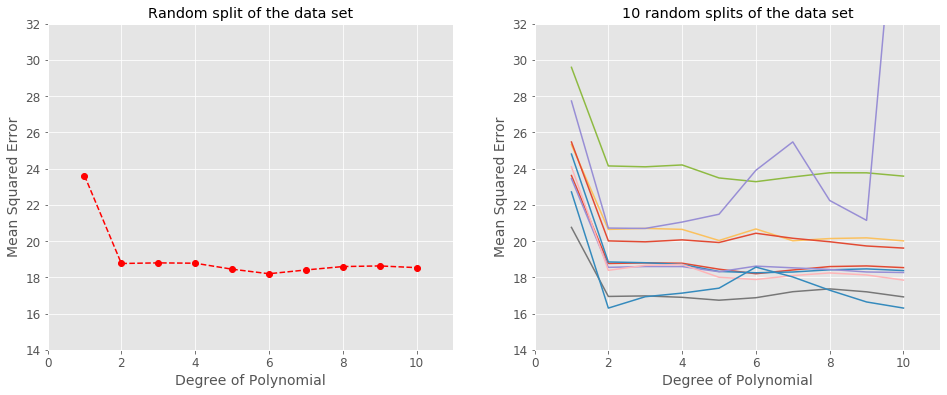

In [4]:
# Plotting
fig, ax = plt.subplots(1,2, figsize=(16,6))

# Left plot
ax[0].plot(X.T[0],Z.T[0], '--ro')
ax[0].set_title('Random split of the data set')

# Right plot
ax[1].plot(X,Z)
ax[1].set_title('10 random splits of the data set')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(14,32)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(1,11)
    ax.set_xticks(range(0,12,2));

The validation set approach was used on the Auto data set to estimate the test error that results from predicting mpg using polynomial functions of horsepower.
* **Left**: Validation error estimates for a single split into
training and validation data sets.
* **Right**: The validation method was repeated ten times, each time using a different random split of the observations into a training
set and a validation set. This illustrates the variability in the estimated test MSE that results from this approach.

We can see from the right-hand panel of the above Figure that the validation estimate of the test error rate can be highly variable.  The test error is highly dependant on the selection of the training set and from the observations set.

Moreover, in the validation approach, only a subset of the observations, the training set, are used to fit the model. Statistical methods tend to perform worse when *trained on fewer observations*, and the validation set error rate may tend to overestimate the test error rate for the model fit on the entire data set.

### Leave-One-Out Cross-Validation

Leave-One-Out Cross-Validation attempts to address that the drawbacks of the validation. In this method, a single observation $(x_i ,y_i)$ is used for the validation (the validationn consideres two subsets of comparable size set). The remaining observations ${(x_1 ,y _1 ),~(x_2 ,y_2 ),\ldots,(x_{i-1} ,y_{i-1} ),(x_{i+1} ,y_{i+1} ),(x_n ,y_n )}$ make up the training set. In other words, the statistical learning method is fit on the $n − 1$ training observations, and using its value $x_1$, a prediction $\hat{y}_1$ is made for the excluded observation.

Furthermore, the LOOCV estimate for the test MSE is the average of these $n$ test error estimates:
$$CV_{(n)} =\dfrac{1}{n} \sum_{i=1}^{n} \left(\dfrac{(y_i −  \hat{y}_i }{1-h_i}\right)^2 $$

where $\hat{y}_i$ is the ith fitted value from the original least squares fit, and $h_i$ is the leverage defined $i$

$$h_{i} = \dfrac{1}{n} +\dfrac{(x_i − \bar{x})^2}{\sum_{i'=1}^{n}(x_i' − \bar{x})^2}$$

LOOCV has the potential to be expensive to implement since the model has to be fit $n$ times. This can be very time consuming if $n$ is large, and if each model is slow to fit.

Given the fact that $(x_i, y_i)$ is not used in the fitting process, $MSE_i = (y_i −  \hat{y}_i )^2$ provides an approximately *unbiased* estimate for the test error. Nevertheless, this unbiased for the test error is a poor estimate because it is highly variable and it is based upon a single observation $(x_i, y_i)$.

In [5]:
polynomial_order = np.arange(1,11)
random_state = np.arange(0,10)

# LeaveOneOut CV
lreg = skl_lm.LinearRegression()
LOO = LeaveOneOut()
# the number of splitting iterations in the cross-validator
LOO.get_n_splits(df)

392

In [6]:
scores = np.zeros(len(polynomial_order))
for i in polynomial_order:
    # Generating polynomial features
    poly = PolynomialFeatures(i)
    X_poly = poly.fit_transform(df.horsepower.values.reshape(-1,1))
    scores[i-1]=cross_val_score(lreg, X_poly, df.mpg, cv=LOO, scoring='neg_mean_squared_error').mean()

In [7]:
scores

array([-24.23151352, -19.24821312, -19.33498406, -19.42443031,
       -19.03321184, -18.97301274, -19.12563966, -19.22423029,
       -19.1338565 , -18.94583744])

### k-fold CV

An alternative to LOOCV is k-fold CV which involves randomly dividing the set of observations into $k$ groups (or folds) of approximately equal size. A fold set is treated as a validation set, and then the method is fit on the remaining $k − 1$ folds. The mean squared error, $MSE_i$, is then computed on the observations in the held-out fold. This process results in $k$ estimates of the test error, $MSE_1$, $MSE_2, \ldots,~MSE_k$. The k-fold CV estimate is computed by averaging these values,
$$CV_{(k)}= \frac{1}{k} \sum_{i}^{k} MSE_{i}. $$

As can be seen, LOOCV is a special case of k-fold CV in which $k=n$. k-fold CV often provides more accurate estimates of the test error rate than does LOOCV

In [8]:
# k-fold CV
folds = 10
elements = len(df.index)

X, Y = np.meshgrid(polynomial_order, random_state, indexing='ij')
Z = np.zeros((polynomial_order.size,random_state.size))

regr = skl_lm.LinearRegression()

for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(X[i,j])
    X_poly = poly.fit_transform(df.horsepower.values.reshape(-1,1))
    kf_10 = KFold(n_splits=folds, random_state=Y[i,j])
    Z[i,j] = cross_val_score(regr, X_poly, df.mpg, cv=kf_10, scoring='neg_mean_squared_error').mean()    

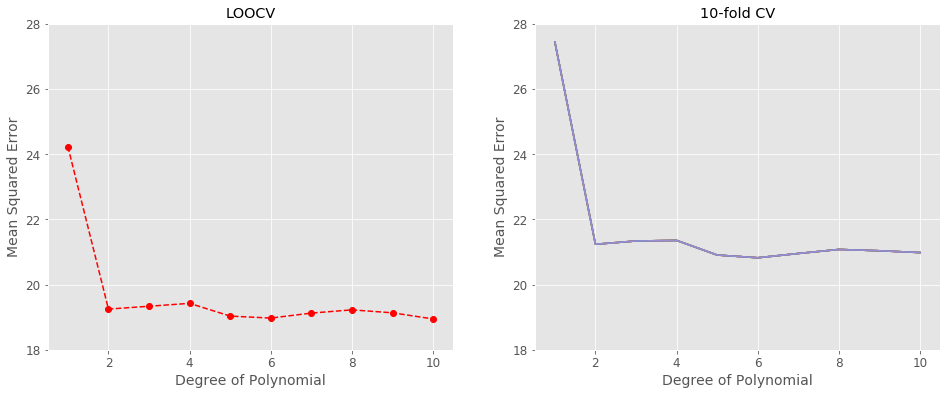

In [9]:
# Plotting
fig, ax = plt.subplots(1,2, figsize=(16,6))

# Left plot
ax[0].plot(polynomial_order, np.array(scores)*-1, '--ro')
ax[0].set_title('LOOCV')

# Right plot
ax[1].plot(X,Z*-1)
ax[1].set_title('10-fold CV')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(18,28)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));

Cross-validation was used on the Auto data set for estimating the test error that results from predicting mpg using polynomial functions
of horsepower. 

* **Left**: The LOOCV error curve.
* **Right**: 10-fold CV was run nine separate times, each with a different random split of the data into ten parts. The figure shows the nine lightly different CV error curves.

## The Bootstrap

[Bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) is a  statistical tool that can be used to quantify the uncertainty associated with a given estimator or statistical learning method. Applying Bootstrap allows allocating measures of accuracy to sample estimates.

## LAB

Consider the Auto example again. We can select a random subset of 200 observations out of the original 392 observations as the **train set**.

In [10]:
# selecting a random subset of 200
subset_size=200
sub_train= df.sample(subset_size, random_state = 1)
X_train = sub_train['horsepower'].values.reshape(-1,1)
y_train = sub_train['mpg']

and the remaining of the observations can be regarded as the test set.

In [11]:
# the remaining of the observations
sub_test = df[~df.isin(sub_train)].dropna(how = 'all')
X_test = sub_test['horsepower'].values.reshape(-1,1)
y_test = sub_test['mpg']

Now, estimate the test error for the linear, quadratic and cubic regressions.

In [12]:
# Linear
reg = skl_lm.LinearRegression().fit(X_train, y_train)
prediction_Linear = reg.predict(X_test)
print('MSE (Linear) = %f' % mean_squared_error(y_test, prediction_Linear))

# Quadratic
poly = PolynomialFeatures(degree=2)
X_train2 = poly.fit_transform(X_train)
X_test2 = poly.fit_transform(X_test)

reg = skl_lm.LinearRegression().fit(X_train2, y_train)
prediction_Quadratic = reg.predict(X_test2)
print('MSE (Quadratic) = %f' % mean_squared_error(y_test, prediction_Quadratic))

# Cubic
poly = PolynomialFeatures(degree=3)
X_train3 = poly.fit_transform(X_train)
X_test3 = poly.fit_transform(X_test)

reg = skl_lm.LinearRegression().fit(X_train3, y_train)
prediction_Cubic = reg.predict(X_test3)
print('MSE (Cubic) = %f' % mean_squared_error(y_test, prediction_Cubic))

MSE (Linear) = 23.555921
MSE (Quadratic) = 20.409870
MSE (Cubic) = 20.488458


In [13]:
Table=pd.DataFrame({'MSE': [mean_squared_error(y_test, prediction_Linear),
                            mean_squared_error(y_test, prediction_Quadratic),
                            mean_squared_error(y_test, prediction_Cubic)]})
Table.rename(index={0:'Linear', 1:'Quadratic', 2:'Cubic'}, inplace=True)
Table

,MSE
Linear,23.555921
Quadratic,20.409870
Cubic,20.488458


If we choose a different training set instead, then we will obtain somewhat different errors on the validation set.

In [14]:
# selecting a random subset of 200
subset_size=200
sub_train= df.sample(subset_size, random_state = 2)
X_train = sub_train['horsepower'].values.reshape(-1,1)
y_train = sub_train['mpg']
# the remaining of the observations
sub_test = df[~df.isin(sub_train)].dropna(how = 'all')
X_test = sub_test['horsepower'].values.reshape(-1,1)
y_test = sub_test['mpg']

# Linear
reg = skl_lm.LinearRegression().fit(X_train, y_train)
prediction_Linear = reg.predict(X_test)
print('MSE (Linear) = %f' % mean_squared_error(y_test, prediction_Linear))

# Quadratic
poly = PolynomialFeatures(degree=2)
X_train2 = poly.fit_transform(X_train)
X_test2 = poly.fit_transform(X_test)

reg = skl_lm.LinearRegression().fit(X_train2, y_train)
prediction_Quadratic = reg.predict(X_test2)
print('MSE (Quadratic) = %f' % mean_squared_error(y_test, prediction_Quadratic))

# Cubic
poly = PolynomialFeatures(degree=3)
X_train3 = poly.fit_transform(X_train)
X_test3 = poly.fit_transform(X_test)

reg = skl_lm.LinearRegression().fit(X_train3, y_train)
prediction_Cubic = reg.predict(X_test3)
print('MSE (Cubic) = %f' % mean_squared_error(y_test, prediction_Cubic))

Table=pd.DataFrame({'MSE': [mean_squared_error(y_test, prediction_Linear),
                            mean_squared_error(y_test, prediction_Quadratic),
                            mean_squared_error(y_test, prediction_Cubic)]})
Table.rename(index={0:'Linear', 1:'Quadratic', 2:'Cubic'}, inplace=True)
Table

MSE (Linear) = 25.502941
MSE (Quadratic) = 19.928762
MSE (Cubic) = 20.113070


,MSE
Linear,25.502941
Quadratic,19.928762
Cubic,20.113070


These results are consistent with our previous findings: a model that predicts mpg using a quadratic function of horsepower performs better than a model that involves only a linear function of horsepower , and there is little evidence in favor of a model that uses a cubic function of horsepower.

### Leave-One-Out Cross-Validation (LOO CV)

In [15]:
x = df['horsepower'].values.reshape(-1,1)
y = df['mpg']

reg = skl_lm.LinearRegression()
clf = reg.fit(x,y)
print(clf.coef_, clf.intercept_)

[-0.15784473] 39.93586102117047


In [16]:
Results = smf.ols('mpg ~ horsepower', df).fit()
Results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,39.9359,0.717,55.660,0.000,38.525,41.347
horsepower,-0.1578,0.006,-24.489,0.000,-0.171,-0.145


In [17]:
xn= PolynomialFeatures(degree=1).fit_transform(x)
cv = reg.fit(xn,y)

### The Bootstrap Analysis

Consider the following ISLR Portfolio data set.

In [18]:
Portfolio = pd.read_csv('Data/Portfolio.csv')
Portfolio.head()

,X,Y
0,-0.895251,-0.234924
1,-1.562454,-0.885176
2,-0.417090,0.271888
3,1.044356,-0.734198
4,-0.315568,0.841983


Illustrating the use of the bootstrap on this data, we must first create a function **alpha(X, Y, Index )** which takes as input the $(X, Y )$ data as well as a vector indicating which observations should be used to estimate $\alpha$. The function then outputs the estimate for $\alpha$ based on the selected observations. This function is defined as

$$\alpha(X, Y)=\frac{var(Y)-cov(X,Y)}{var(X)+var(Y)-2cov(X,Y))}$$

In [19]:
def alpha(x,y, Index):
    X=x[Index]
    Y=y[Index]
    return ((np.var(Y)-np.cov(X,Y)[0,1])/(np.var(X)+np.var(Y)-2*np.cov(X,Y)[0,1]))

Now,

In [20]:
Index=np.arange(0,100)
print('alpha(X,Y,Index)= %f' % alpha(Portfolio.X.values,Portfolio.Y.values, Index))

alpha(X,Y,Index)= 0.576651


The next command uses the **sample()** function to randomly select 100 observations from the range 1 to 100, with replacement. This is equivalent to constructing a new bootstrap data set and recomputing $\hat{\alpha}$ based on the new data set.

In [21]:
Portfolio_Sample = Portfolio.sample(frac=1, replace=True)
Portfolio_Sample.head()

,X,Y
92,-1.295764,-1.085204
63,-1.012708,-0.924769
75,2.460336,-0.048373
85,0.075727,-0.522149
67,1.302851,1.104666


In [22]:
Index=np.arange(0,100)
print('alpha(X,Y,Index)= %f' % alpha(Portfolio_Sample.X.values,Portfolio_Sample.Y.values, Index))

alpha(X,Y,Index)= 0.635883


We can implement a [bootstrap](https://docs.astropy.org/en/stable/api/astropy.stats.bootstrap.html) analysis.

In [23]:
with NumpyRNGContext(1):
    bootresult = bootstrap(np.asarray(Portfolio), bootnum=1000)